In [ ]:
# All imports go here
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
import scispacy
import re
import en_core_sci_md
import warnings
from sklearn.manifold import TSNE
import gensim.downloader as api
warnings.filterwarnings("ignore")

# Extract entities using all methods (Functions only)

In [ ]:
# Extract entities using Spacy
def extract_entities(df, nlp):
    corpus = []
    for row in range(0, len(df)):
        str_tokens=[]
        tokens = nlp(df[row]).ents

        for token in tokens:
            clean_token = token.text.strip()
            clean_token = re.sub(r"^a-zA-Z]", "", clean_token)

            if clean_token:
                if clean_token.isnumeric():
                    continue
                else:
                    try :
                        int(clean_token.lower())
                        float(clean_token.lower())
                    except:
                        str_tokens.append(clean_token)

        corpus.append(list(str_tokens))
    return corpus

In [ ]:
# Plot the extracted entities
def plot_entities(model, words, title, use_wv=True, map_size=(16, 16)):
    labels = []
    tokens = []

    for word in words:
        if use_wv:
            if word in model.wv:
                tokens.append(model.wv[word])
                labels.append(word)
            else:
                print(f"skipping {word}")
        else:
            if word in model:
                tokens.append(model[word])
                labels.append(word)
            else:
                print(f"skipping {word}")

    tnse_model = TSNE(perplexity=11, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tnse_model.fit_transform(np.array(tokens))

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]

    plt.figure(figsize=map_size)
    plt.title(title)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    plt.grid(True)
    plt.show()

# Run the pipeline

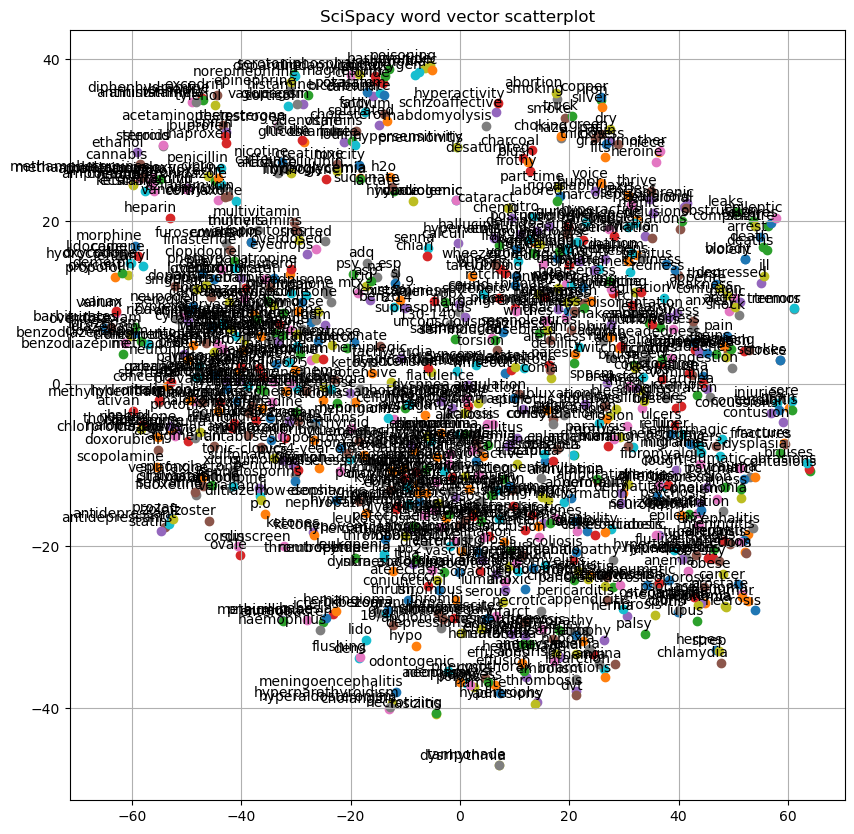

In [25]:
# Call above functions to run the pipeline
_adhd_notes_file = 'dataframe_output/adhd_lg.csv'
_map_size = (10,10)

# NLPs
spacy_nlp = spacy.load('en_core_web_sm')
scispacy_nlp = en_core_sci_md.load()
ner_nlp = spacy.load("en_ner_bc5cdr_md")
p_model = api.load("glove-wiki-gigaword-50")

# Load the data
adhd_note_word_list = []
with open(_adhd_notes_file, 'r') as file:
    lines = file.readlines()
    for line in lines:
        adhd_note_word_list.append(line)

# Spacy
spacy_corpus = extract_entities(adhd_note_word_list, spacy_nlp)
spacy_embeddings = word2vec.Word2Vec(spacy_corpus, min_count=1)
spacy_vocab = spacy_embeddings.wv.index_to_key
spacy_vector = np.array(list(spacy_vocab))
spacy_words = [word for word in spacy_vector if word in p_model.key_to_index]
plot_entities(p_model, spacy_words, "Spacy word vector scatterplot", use_wv=False, map_size=_map_size)

# Scispacy
sci_corpus = extract_entities(adhd_note_word_list, ner_nlp)
sci_embeddings = word2vec.Word2Vec(sci_corpus, min_count=1)
sci_vocab = sci_embeddings.wv.index_to_key
sci_vector = np.array(list(sci_vocab))
sci_words = [word for word in sci_vector if word in p_model.key_to_index]
plot_entities(p_model, sci_words, "SciSpacy word vector scatterplot",use_wv=False, map_size=_map_size)

In [26]:
from collections import Counter

# Flatten the corpus into one big list of entities
all_entities = [entity for doc in spacy_corpus for entity in doc]

# Count how often each entity appears
entity_frequency = Counter(all_entities)

print(entity_frequency.most_common(10))


[('\\n', 3762), ('IV', 1310), ('CT', 1132), ('First', 1108), ('One', 1083), ('ICU', 972), ('#', 937), ('Tablet', 889), ('PO', 788), ('un', 779)]
